In [15]:
import pickle
import netCDF4
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

def load_variable(key, index):
    # key: mrso, snc, tos, tsl
    list = [f"{key}_raw",
            f"{key}_anom",
            f"{key}_clim",
            f"{key}_std",
            f"{key}_variance",
            f"{key}_coarse",
            f"{key}_coarse_anom",
            f"{key}_coarse_clim",
            f"{key}_coarse_std",
            f"{key}_coarse_variance"]
    
    path = f"/work/kajiyama/cnn/input/{key}/{list[index]}.npy"
    variable = np.load(path)
    return variable

def load_prcp(key):
    path = f"/work/kajiyama/cnn/input/pr/{key}"
    prcp = np.load(path)
    return prcp

def open_pickle(file):
    with open(file, 'rb') as f:
        data = pickle.load(f)
    return data

def fill(x):
    f = ma.filled(x, fill_value=99999)
    return f

def mask(x):
    m = ma.masked_where(x>9999, x)
    return m

def conc(x, center_index=180, conc_dim=2):
    c = x.copy()
    c = fill(c)
    # modify depending on dim_size (model_ind, year_ind, lat, lon) expected in default
    x1, x2 = c[:, :, -center_index:], c[:, :, :center_index] # month, lat, lon
    c = np.concatenate([x1, x2], conc_dim)
    return c

def show(img):
    plt.imshow(img)
    plt.colorbar()
    plt.show()

# [tos] npyファイルの検証

(42, 165, 12, 120, 360)


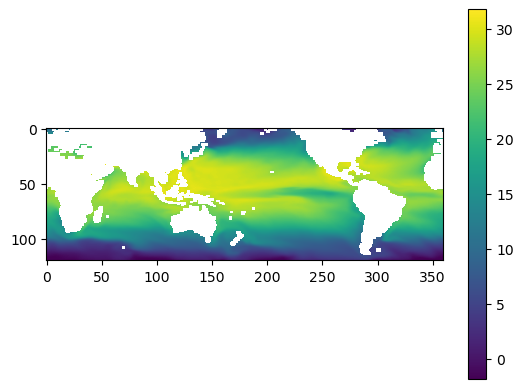

In [16]:
# key: mrso, snc, tos, tsl
key = "tos"
data = load_variable(key, 0)
print(data.shape)
data_masked = mask(data)
show(data_masked[1,0, 7, :, :])

# [prcp] npyファイルの検証

(42, 165, 120, 360)


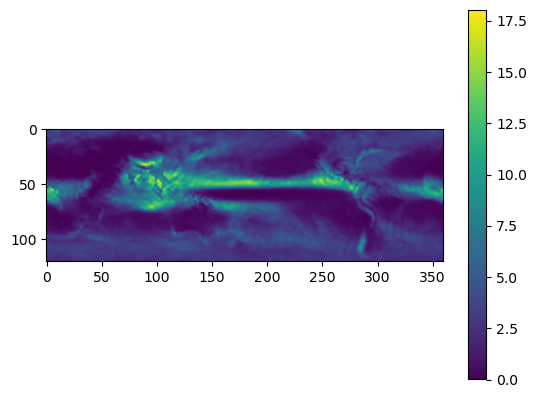

In [25]:
key = "continuous/world/1x1/pr_1x1_raw_MJJASO_world.npy"
#key = "continuous/world/5x5/pr_5x5_coarse_MJJASO_world.npy"
data = load_prcp(key)
print(data.shape)
show(data[0, 0, :, :])

# Pickleファイルの検証

dict_keys(['tos_raw', 'tos_clim', 'tos_variance', 'tos_anom', 'tos_std', 'tos_coarse', 'tos_coarse_clim', 'tos_coarse_variance', 'tos_coarse_anom', 'tos_coarse_std'])
(12, 24, 72)


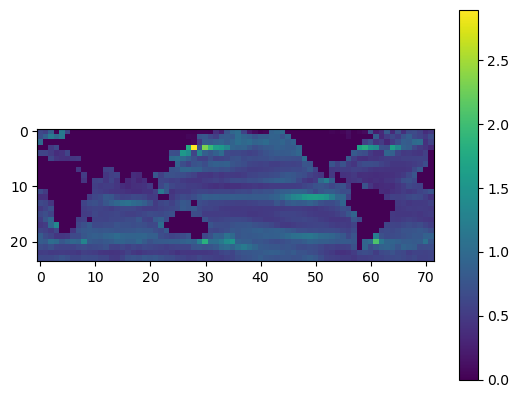

In [18]:
# keys: raw, anom, clim, std, variance, coarse, coarse_anom, coarse_clim, coarse_std, coarse_variance
path = "/work/kajiyama/preprocessed/cmip6/AWI-ESM-1-1-LR/tos_AWI-ESM-1-1-LR.pickle"
data = open_pickle(path)
print(data.keys())
raw = data['tos_coarse_variance']
raw = mask(raw)
print(raw.shape)
show(raw[0,:,:])

# netCDFファイルの検証

(12, 180, 360)


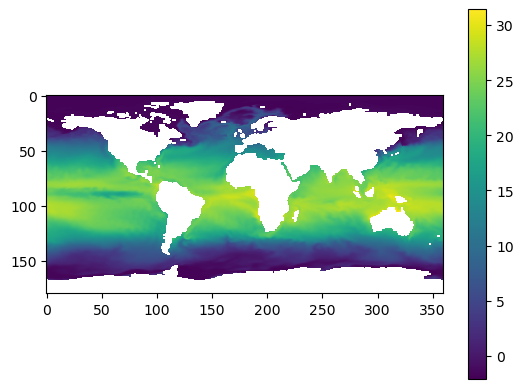

In [19]:
path = "/work/kajiyama/cdo/cmip6/AWI-ESM-1-1-LR/tos/tos_1850-1850.nc"
ds =  netCDF4.Dataset(path, 'r')
tos = ds.variables['tos'][:]
tos = tos[:, ::-1, :]
print(tos.shape)
show(tos[0])

(12, 120, 360)


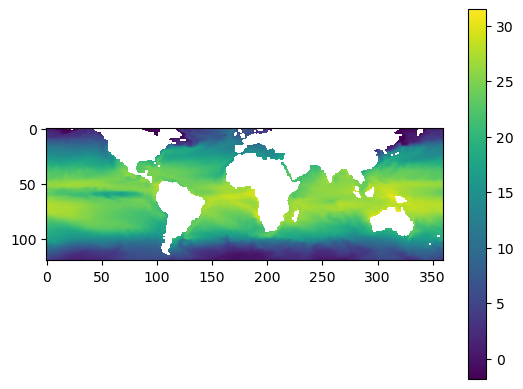

In [20]:
path = "/work/kajiyama/cdo/cmip6/AWI-ESM-1-1-LR/tos/tos_1850-1850.nc"
ds =  netCDF4.Dataset(path, 'r')
tos = ds.variables['tos'][:]
tos = tos[:, ::-1, :]
ulim, llim = 30, -30
tos_trim = tos[:, ulim:llim, :]
print(tos_trim.shape)
show(tos_trim[0])

(12, 120, 360)


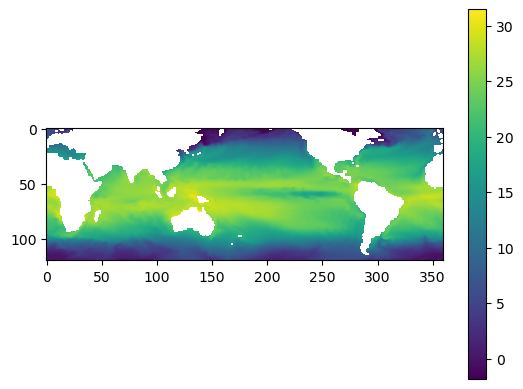

In [21]:
path = "/work/kajiyama/cdo/cmip6/AWI-ESM-1-1-LR/tos/tos_1850-1850.nc"
ds =  netCDF4.Dataset(path, 'r')
tos = ds.variables['tos'][:]
tos = tos[:, ::-1, :]
ulim, llim = 30, -30
tos_trim = tos[:, ulim:llim, :]
tos_conc = conc(tos_trim, center_index=180, conc_dim=2)
tos_conc_mask = mask(tos_conc)
print(tos_conc.shape)
show(tos_conc_mask[0])

# make_val in preprocessing/model/anom_coarse_conc.py再現

In [22]:
def load_val(path, variable):
    ds = netCDF4.Dataset(path, 'r')
    val = ds.variables[variable][:]
    val = val[:, ::-1, :]
    trim = val[:, ulim:llim, :]
    cnc = conc(trim, center_index=180, conc_dim=2)
    return cnc

def make_val():
    lt, ln = 120, 360
    
    model = 'AWI-ESM-1-1-LR'
    variable = 'tos'
    datadir = f"/work/kajiyama/cdo/cmip6/{model}/{variable}"
    
    first_begin, first_end = 1850, 1850
    first_file =  f"{datadir}/{variable}_{first_begin}-{first_end}.nc"
    
    last_begin, last_end = 2011, 2014
    last_file = f"{datadir}/{variable}_{last_begin}-{last_end}.nc"
    
    timestep_loop = 10
    data_num = 12*timestep_loop
    first_data_num = 12*(first_end - first_begin + 1)
    last_data_num = 12*(last_end - last_begin + 1)
    
    start_loop, stop_loop = 1851, 2010
    loopyr = (stop_loop - start_loop + 1)/timestep_loop
    tm = int(data_num*loopyr + first_data_num + last_data_num)
    
    val = np.empty((tm, lt, ln))
    
    val[:first_data_num, :, :] = fill(load_val(first_file, variable))
    ind = data_num
    for i in range(start_loop, stop_loop+1, timestep_loop):
        file = f"{datadir}/{variable}_{i}-{i+timestep_loop-1}.nc"
        val[(first_data_num + ind - data_num):(first_data_num + ind), :, :] = fill(load_val(file, variable))
        ind += data_num
        print(i)
    
    val[-last_data_num:, :, :] = fill(load_val(last_file, variable))
    val = mask(val)
    
    return val

1851
1861
1871
1881
1891
1901
1911
1921
1931
1941
1951
1961
1971
1981
1991
2001
(1980, 120, 360)


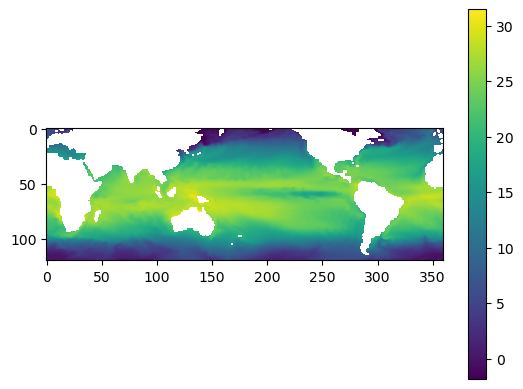

In [23]:
val = make_val()
print(val.shape)
show(val[0,:,:])